In [1]:
import os, sys
dir1 = os.path.abspath('..\..')
sys.path.append(dir1+ "\\")

import MetaTrader5 as mt
from datetime import datetime as dt

# custom
from my_jupyter.user import User
from my_jupyter.strategy_manager import StrategyManager
from my_jupyter.operation import Operation
from my_jupyter.strategies.min_max_strategy import MinMaxStrategy
from my_jupyter.market_data_repository import MarketDataRepository
from my_jupyter.filters.moving_average import MovingAverageFilter
from my_jupyter.filters.consequent_limits_counter import ConsequentLimitsCounterFilter
from my_jupyter.filters.directioned_bars_filter import DirectionedBarsFilter

# from Mbox import Mbox
# from boleta_1 import gerar_boleta
# from gerenciamento import Gerenciamento

## GUI's
from daemon_tools import DaemonThreadMini


In [2]:


filters = [DirectionedBarsFilter(candles=5), MovingAverageFilter(), MovingAverageFilter(period=200)]
strategies = [MinMaxStrategy(filters=filters)]
operations = [Operation("WINV23", 1, mt.TIMEFRAME_M1, can_buy=True, can_sell=True)]
user = User(strategies=strategies, operations=operations, trading_time_start=dt(2023,10,5,9,5,0))
market_data_repository = MarketDataRepository()
strategy = StrategyManager(market_data_repository, user)

# PARAMETROS MAIN
kwargs = {
    "strategy": strategy,
}


def main(**kwargs):
    _shift = 0
    strategy: StrategyManager = kwargs["strategy"]
    strategy.run_strategies()
    # print(f"{dt.now().strftime('%d/%m/%Y, %H:%M:%S')} >>> D-{_shift}")
def exec_daemon(**kwargs):
    main(**kwargs)
    # alarme.ring_alarme()

In [3]:
# gerenciamento = Gerenciamento(mt, timeframe, timeframes_dict)

try:
    main(**kwargs)
except Exception as e:
    print(e.with_traceback(__tb=None))
    # Mbox.Alerta("ERRO", "busca de sinais com erro")


In [4]:
# from my_jupyter.daemons.daemon_tools import DaemonThreadMini


# thread_exec = DaemonThreadMini(exec_daemon, seconds=0, mseconds=800, **kwargs)
# thread_exec.start()

In [1]:
import os, sys

dir1 = os.path.abspath("..\..")

if dir1 not in sys.path:
    sys.path.append(dir1 + "\\")
from my_jupyter.indicator.bars_trend_quality_ml import BarsTrendQualityML
from my_jupyter.market_data_repository import MarketDataRepository
from datetime import datetime as dt 
import pandas as pd 
# mt_rep = MarketDataRepository()
# ohlc = mt_rep.read_data("WINV23",mt_rep.mt.TIMEFRAME_M1,6)
# ohlc = mt_rep.mt.copy_rates_from_pos("WINV23", mt_rep.mt.TIMEFRAME_M1, 0, 99999)
# ohlc_0_based = ohlc[::-1]

# from_file  = "dataset\WINV23M1.csv"
# ohlc_df = pd.DataFrame(ohlc)
bars_trend_ml = BarsTrendQualityML()
bars_trend_ml.set_machine_learning_model(from_stock_market_data="WIN$")


c:\repo\python\financial-api\my_jupyter\modules\backtest_module.py:29: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(


1168 1075
Epoch 1/10
82/82 [==============================] - 1s 6ms/step - loss: 0.8954 - accuracy: 0.7359 - val_loss: 0.6921 - val_accuracy: 0.7931
Epoch 2/10
82/82 [==============================] - 0s 3ms/step - loss: 0.5448 - accuracy: 0.8137 - val_loss: 0.5931 - val_accuracy: 0.7690
Epoch 3/10
82/82 [==============================] - 0s 3ms/step - loss: 0.4605 - accuracy: 0.8172 - val_loss: 0.5825 - val_accuracy: 0.7862
Epoch 4/10
82/82 [==============================] - 0s 3ms/step - loss: 0.4327 - accuracy: 0.8252 - val_loss: 0.5735 - val_accuracy: 0.8069
Epoch 5/10
82/82 [==============================] - 0s 3ms/step - loss: 0.4188 - accuracy: 0.8344 - val_loss: 0.5539 - val_accuracy: 0.8138
Epoch 6/10
82/82 [==============================] - 0s 3ms/step - loss: 0.4060 - accuracy: 0.8394 - val_loss: 0.5428 - val_accuracy: 0.8138
Epoch 7/10
82/82 [==============================] - 0s 3ms/step - loss: 0.3932 - accuracy: 0.8425 - val_loss: 0.5317 - val_accuracy: 0.8241
Epoch 8/10

<Axes: >

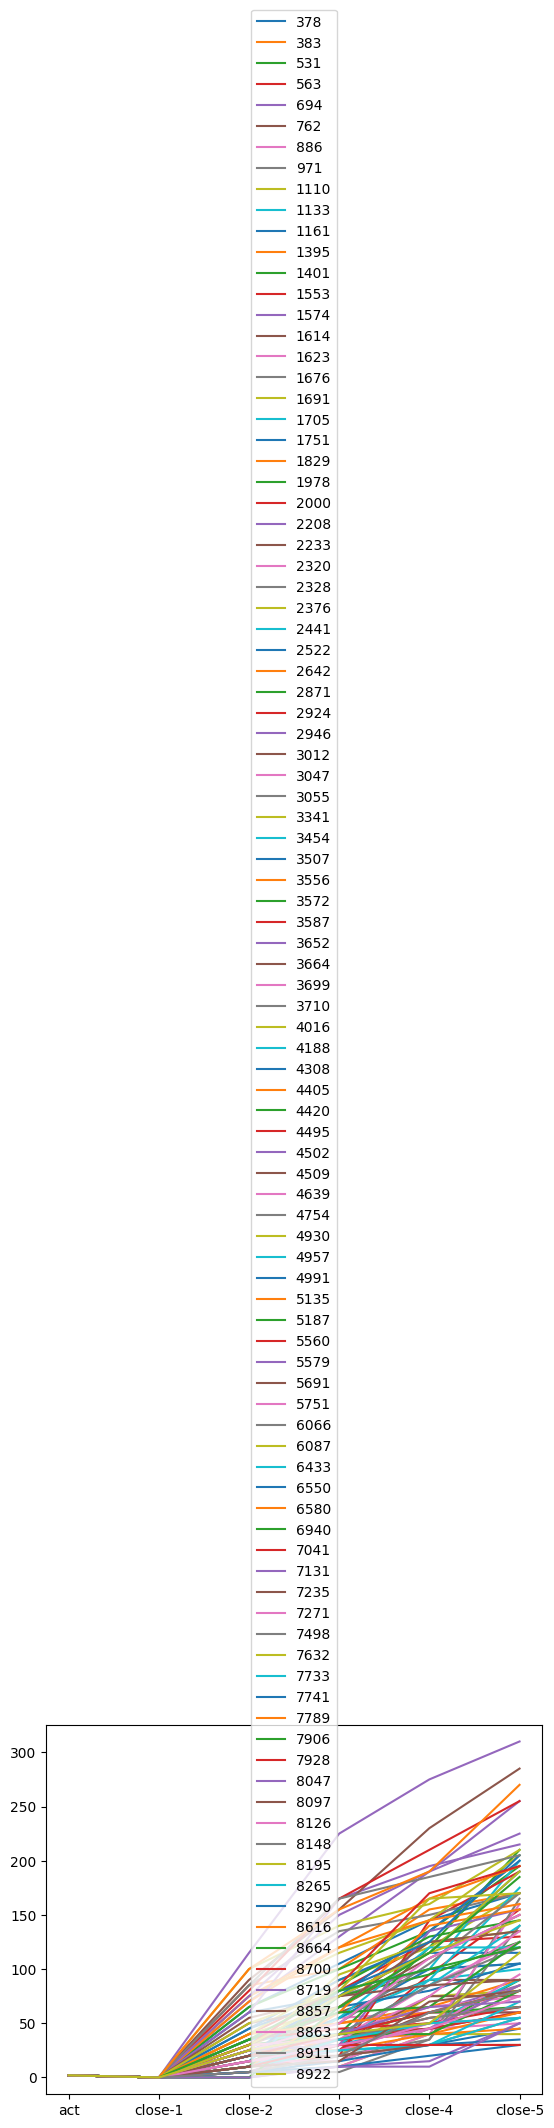

In [3]:
df = bars_trend_ml.df
df[df["act"]==2].iloc[1:100].T.plot()

In [15]:
from my_jupyter.market_data_repository import MarketDataRepository
from datetime import datetime as dt 
mt_rep = MarketDataRepository()
ohlc = mt_rep.read_data("WINV23",mt_rep.mt.TIMEFRAME_M1,6)
ohlc = mt_rep.mt.copy_rates_from_pos("WINV23", mt_rep.mt.TIMEFRAME_M1, 0, 8)
ohlc_0_based = ohlc[::-1]
# print([ dt.fromtimestamp(i[0]) for i in ohlc_0_based])
# bars_trend_ml.output(ohlc_0_based[1:])
import numpy as np
# import logging
# logging.Logger.setLevel(logging.INFO)
ohlc_transform = [ohlc_0_based[i:i+5]["close"] for i in range(1, len(ohlc_0_based)-5)]
ohlc_transform = [ i - min(i) for i in ohlc_transform ]
print(ohlc_0_based[1], ohlc_transform[1])
for i in range(0,len(ohlc_transform)):
    print(">>>>>>>", np.round(bars_trend_ml.output(ohlc_transform[i])*100), dt.fromtimestamp(ohlc_0_based[i]["time"]))


(1696960440, 116840., 116850., 116800., 116830., 357, 5, 4373) [55. 45. 30. 10.  0.]
1/1 [==============================] - 0s 54ms/step
>>>>>>> [[84. 81.  3.]] 2023-10-10 15:01:00
1/1 [==============================] - 0s 35ms/step
>>>>>>> [[87. 80.  2.]] 2023-10-10 14:54:00


c:\repo\python\financial-api\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\repo\python\financial-api\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
